## dependencies
https://microsoft.github.io/SynapseML/docs/features/vw/about/

Install libraries VW from Cluster, magic commads don't work

com.microsoft.azure:synapseml-vw_2.12:0.10.2
Maven

##Loading Data & Exploration

In [0]:
# spark.read.csv() method to load a CSV file from DBFS (Databricks File System) using PySpark.
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

In [0]:
# Load the CSV file into a DataFrame
df = spark.read.csv("dbfs:/FileStore/tables/processed_cleveland.data", header=True, inferSchema=True)

# Assign column names to the DataFrame
df = df.toDF(*['age','sex','cp','trestbps','chol','fbs',
            'restecg','thalach','exang',
            'oldpeak',"slope",'ca','thal','target'])

# Show the first 5 rows of the DataFrame
df.printSchema()

root
 |-- age: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- cp: double (nullable = true)
 |-- trestbps: double (nullable = true)
 |-- chol: double (nullable = true)
 |-- fbs: double (nullable = true)
 |-- restecg: double (nullable = true)
 |-- thalach: double (nullable = true)
 |-- exang: double (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: double (nullable = true)
 |-- ca: string (nullable = true)
 |-- thal: string (nullable = true)
 |-- target: integer (nullable = true)



##Data Preparation & Cleansing

In [0]:
from pyspark.sql.functions import count

df.groupBy("ca").agg(count("*").alias("count")).show()
df.groupBy("thal").agg(count("*").alias("count")).show()

+---+-----+
| ca|count|
+---+-----+
|1.0|   65|
|0.0|  175|
|2.0|   38|
|  ?|    4|
|3.0|   20|
+---+-----+

+----+-----+
|thal|count|
+----+-----+
| 6.0|   17|
| 7.0|  117|
|   ?|    2|
| 3.0|  166|
+----+-----+



In [0]:
#checking string dtype column
df.select('ca').distinct().collect()

Out[243]: [Row(ca='1.0'), Row(ca='0.0'), Row(ca='2.0'), Row(ca='?'), Row(ca='3.0')]

In [0]:
# count the unique values
df.select('ca').distinct().show()

+---+
| ca|
+---+
|1.0|
|0.0|
|2.0|
|  ?|
|3.0|
+---+



In [0]:
# dropping ?
droplist = df.filter(~(df['ca'] == '?')).collect()
df = df.filter(df['ca'] != '?')

In [0]:
from pyspark.sql.types import IntegerType

# Convert String to numeric, safely converted to the Integer data type 
#If there are any values that cannot be converted, this code will raise an exception
df = df.withColumn("ca", df["ca"].cast(IntegerType()))

In [0]:
# lets do the same with thalassemia
df.select('thal').distinct().collect()

Out[247]: [Row(thal='6.0'), Row(thal='7.0'), Row(thal='?'), Row(thal='3.0')]

In [0]:
# Same again
df.select('thal').distinct().show()

+----+
|thal|
+----+
| 6.0|
| 7.0|
|   ?|
| 3.0|
+----+



In [0]:
# dropping ? 
droplist = df.filter(~(df['thal'] == '?')).collect()
df = df.filter(df['thal'] != '?')

In [0]:
df.select('thal').distinct().collect()

Out[250]: [Row(thal='6.0'), Row(thal='7.0'), Row(thal='3.0')]

In [0]:
# And the same again
df = df.withColumn("thal", df["thal"].cast(IntegerType()))

In [0]:
from pyspark.sql.functions import isnull, when, count, col

df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+



In [0]:
df.select('target').distinct().show()

+------+
|target|
+------+
|     1|
|     3|
|     4|
|     2|
|     0|
+------+



In [0]:
# lets do the same with thalassemia
df.select("target").distinct().show()

+------+
|target|
+------+
|     1|
|     3|
|     4|
|     2|
|     0|
+------+



In [0]:
from pyspark.sql.functions import count

df.groupBy("target").agg(count("*").alias("count")).show()


+------+-----+
|target|count|
+------+-----+
|     1|   54|
|     3|   35|
|     4|   13|
|     2|   35|
|     0|  159|
+------+-----+



In [0]:
# Replace 2-4 with 1 to indicate heart disease
df = df.replace(2,1,subset='target')
df = df.replace(3,1,subset='target')
df = df.replace(4,1,subset='target')

In [0]:
df.groupBy("target").agg(count("*").alias("count")).show()


+------+-----+
|target|count|
+------+-----+
|     1|  137|
|     0|  159|
+------+-----+



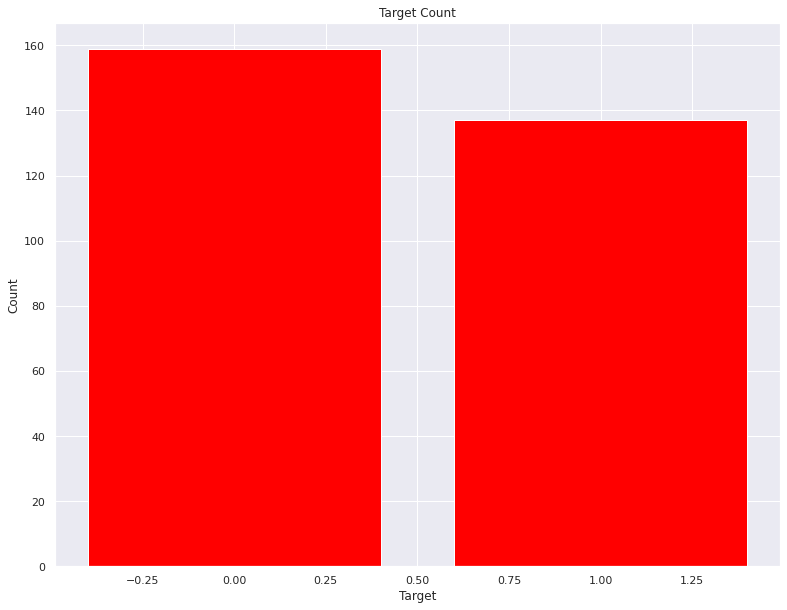

In [0]:
import matplotlib.pyplot as plt

# Get the data
data = df.groupBy("target").agg(count("*").alias("count")).toPandas()

# Plot the bar chart
plt.bar(data['target'], data['count'], color='red')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Count')
plt.show()


In [0]:
df.printSchema()

root
 |-- age: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- cp: double (nullable = true)
 |-- trestbps: double (nullable = true)
 |-- chol: double (nullable = true)
 |-- fbs: double (nullable = true)
 |-- restecg: double (nullable = true)
 |-- thalach: double (nullable = true)
 |-- exang: double (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: double (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [0]:
#seperate df for feature importance
df1 = df

## Test & Train Split

In [0]:
train, test = df.randomSplit([0.85, 0.15], seed=1)

In [0]:
from synapse.ml.vw import VowpalWabbitFeaturizer

#VowpalWabbitFeaturizer is used to convert your input data into a format that is compatible with VW
#it does do a lot of the heavy lifting for you, as it takes care of the feature engineering and learning the model.
featurizer = VowpalWabbitFeaturizer(inputCols=df.columns[:-1], outputCol="features")
train_data = featurizer.transform(train)["target", "features"]
test_data = featurizer.transform(test)["target", "features"]

In [0]:
df

Out[295]: DataFrame[age: double, sex: double, cp: double, trestbps: double, chol: double, fbs: double, restecg: double, thalach: double, exang: double, oldpeak: double, slope: double, ca: int, thal: int, target: int]

In [0]:
display(train_data.groupBy("target").count())

target,count
1,117
0,138


##Fit & Evaluate Models

###Vowpal Wabbit Classifier

In [0]:
from synapse.ml.vw import VowpalWabbitClassifier

model = VowpalWabbitClassifier(
    numPasses=20, labelCol="target", featuresCol="features"
).fit(train_data)

In [0]:
predictions = model.transform(test_data)
display(predictions)

target,features,rawPrediction,probability,prediction
0,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 566294787, 727702608, 822174710, 845852020, 963448256), values -> List(3.0, 1.0, 2.0, 174.0, 122.0, 192.0, 1.0, 35.0))",-0.8292921781539917,"Map(vectorType -> dense, length -> 2, values -> List(0.6962052438187964, 0.30379475618120355))",0.0
1,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 369166886, 566294787, 727702608, 822174710, 845852020, 963448256), values -> List(7.0, 2.0, 4.0, 1.2, 140.0, 118.0, 219.0, 1.0, 39.0))",0.19292151927947998,"Map(vectorType -> dense, length -> 2, values -> List(0.45191865490373895, 0.548081345096261))",1.0
1,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 369166886, 566294787, 727702608, 822174710, 836350197, 845852020, 963448256, 1051066065), values -> List(7.0, 2.0, 4.0, 2.0, 114.0, 110.0, 167.0, 2.0, 1.0, 40.0, 1.0))",1.0,"Map(vectorType -> dense, length -> 2, values -> List(0.2689414213699951, 0.7310585786300049))",1.0
0,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 554480855, 566294787, 727702608, 822174710, 963448256), values -> List(3.0, 1.0, 2.0, 1.0, 168.0, 105.0, 198.0, 41.0))",-0.7131524085998535,"Map(vectorType -> dense, length -> 2, values -> List(0.6710973523191899, 0.3289026476808102))",0.0
0,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 369166886, 554480855, 566294787, 727702608, 822174710, 836350197, 845852020, 963448256), values -> List(3.0, 1.0, 1.0, 0.8, 2.0, 178.0, 148.0, 244.0, 2.0, 1.0, 42.0))",0.014323770999908447,"Map(vectorType -> dense, length -> 2, values -> List(0.4964191184740595, 0.5035808815259405))",1.0
0,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 566294787, 727702608, 822174710, 845852020, 963448256), values -> List(3.0, 1.0, 3.0, 150.0, 130.0, 180.0, 1.0, 42.0))",-0.6640393733978271,"Map(vectorType -> dense, length -> 2, values -> List(0.660167193062287, 0.339832806937713))",0.0
1,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 369166886, 566294787, 727702608, 822174710, 845852020, 963448256, 1051066065), values -> List(6.0, 2.0, 4.0, 1.8, 125.0, 136.0, 315.0, 1.0, 42.0, 1.0))",0.5214200019836426,"Map(vectorType -> dense, length -> 2, values -> List(0.3725202497258372, 0.6274797502741628))",1.0
0,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 566294787, 727702608, 822174710, 845852020, 963448256), values -> List(3.0, 1.0, 2.0, 170.0, 120.0, 220.0, 1.0, 44.0))",-0.8815131187438965,"Map(vectorType -> dense, length -> 2, values -> List(0.7071356783177365, 0.29286432168226345))",0.0
0,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 369166886, 566294787, 727702608, 822174710, 836350197, 845852020, 963448256, 1051066065), values -> List(3.0, 2.0, 4.0, 3.0, 148.0, 104.0, 208.0, 2.0, 1.0, 45.0, 1.0))",0.5553783178329468,"Map(vectorType -> dense, length -> 2, values -> List(0.3646175006993372, 0.6353824993006628))",1.0
1,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 369166886, 566294787, 727702608, 822174710, 845852020, 963448256), values -> List(3.0, 2.0, 3.0, 3.6, 147.0, 150.0, 231.0, 1.0, 46.0))",-0.2377321720123291,"Map(vectorType -> dense, length -> 2, values -> List(0.5591547032566095, 0.44084529674339046))",0.0


In [0]:
from synapse.ml.train import ComputeModelStatistics

metrics = ComputeModelStatistics(
    evaluationMetric="classification", labelCol="target", scoredLabelsCol="prediction"
).transform(predictions)
display(metrics)

evaluation_type,confusion_matrix,accuracy,precision,recall,AUC
Classification,17.0 4.0 4.0 16.0,0.8048780487804879,0.8,0.8,0.8047619047619048


<command-3794937828896069>:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


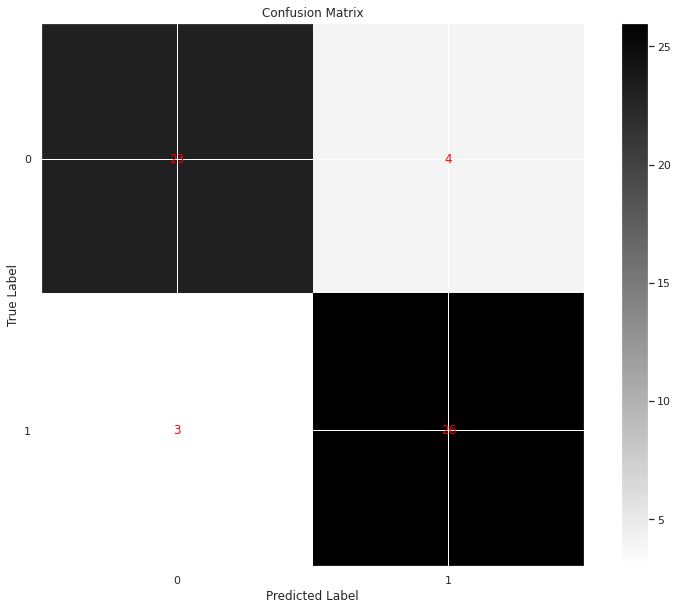

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Example confusion matrix data
confusion_matrix = np.array([[23, 4], [3, 26]])

# Plot the confusion matrix
plt.imshow(confusion_matrix, cmap='binary')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='red')
plt.show()


###Vowpal Wabbit Classifier: Cross Validation

In [0]:
from synapse.ml.vw import VowpalWabbitClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the hyperparameters to search over
param_grid = ParamGridBuilder() \
    .addGrid(VowpalWabbitClassifier.numPasses, [10, 20, 30]) \
    .addGrid(VowpalWabbitClassifier.learningRate, [0.1, 0.5, 1.0]) \
    .build()

# Define the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="target")

# Define the cross-validator
cv = CrossValidator(
    estimator=VowpalWabbitClassifier(labelCol="target", featuresCol="features"), 
    estimatorParamMaps=param_grid, 
    evaluator=evaluator,
    numFolds=3
)

# Fit the cross-validator on the training data
model = cv.fit(train_data)


In [0]:
test_data.head()

Out[302]: Row(target=0, features=SparseVector(1073741824, {38204137: 3.0, 131375559: 1.0, 186889001: 2.0, 566294787: 174.0, 727702608: 122.0, 822174710: 192.0, 845852020: 1.0, 963448256: 35.0}))

In [0]:
# Use the model to make predictions on test data
predictions = model.transform(test_data)

# Display the predictions
display(predictions)


target,features,rawPrediction,probability,prediction
0,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 566294787, 727702608, 822174710, 845852020, 963448256), values -> List(3.0, 1.0, 2.0, 174.0, 122.0, 192.0, 1.0, 35.0))",-0.5021900534629822,"Map(vectorType -> dense, length -> 2, values -> List(0.6229738636961726, 0.3770261363038274))",0.0
1,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 369166886, 566294787, 727702608, 822174710, 845852020, 963448256), values -> List(7.0, 2.0, 4.0, 1.2, 140.0, 118.0, 219.0, 1.0, 39.0))",-0.1647445112466812,"Map(vectorType -> dense, length -> 2, values -> List(0.541093228060242, 0.45890677193975804))",0.0
1,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 369166886, 566294787, 727702608, 822174710, 836350197, 845852020, 963448256, 1051066065), values -> List(7.0, 2.0, 4.0, 2.0, 114.0, 110.0, 167.0, 2.0, 1.0, 40.0, 1.0))",0.6143600940704346,"Map(vectorType -> dense, length -> 2, values -> List(0.3510652442277754, 0.6489347557722246))",1.0
0,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 554480855, 566294787, 727702608, 822174710, 963448256), values -> List(3.0, 1.0, 2.0, 1.0, 168.0, 105.0, 198.0, 41.0))",-0.5184893012046814,"Map(vectorType -> dense, length -> 2, values -> List(0.6267944466095895, 0.3732055533904105))",0.0
0,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 369166886, 554480855, 566294787, 727702608, 822174710, 836350197, 845852020, 963448256), values -> List(3.0, 1.0, 1.0, 0.8, 2.0, 178.0, 148.0, 244.0, 2.0, 1.0, 42.0))",0.09722340106964111,"Map(vectorType -> dense, length -> 2, values -> List(0.4757132773500483, 0.5242867226499517))",1.0
0,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 566294787, 727702608, 822174710, 845852020, 963448256), values -> List(3.0, 1.0, 3.0, 150.0, 130.0, 180.0, 1.0, 42.0))",-0.47094953060150146,"Map(vectorType -> dense, length -> 2, values -> List(0.6156084729132583, 0.3843915270867418))",0.0
1,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 369166886, 566294787, 727702608, 822174710, 845852020, 963448256, 1051066065), values -> List(6.0, 2.0, 4.0, 1.8, 125.0, 136.0, 315.0, 1.0, 42.0, 1.0))",0.26832979917526245,"Map(vectorType -> dense, length -> 2, values -> List(0.43331717275945614, 0.5666828272405439))",1.0
0,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 566294787, 727702608, 822174710, 845852020, 963448256), values -> List(3.0, 1.0, 2.0, 170.0, 120.0, 220.0, 1.0, 44.0))",-0.5436251163482666,"Map(vectorType -> dense, length -> 2, values -> List(0.6326553085042731, 0.3673446914957269))",0.0
0,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 369166886, 566294787, 727702608, 822174710, 836350197, 845852020, 963448256, 1051066065), values -> List(3.0, 2.0, 4.0, 3.0, 148.0, 104.0, 208.0, 2.0, 1.0, 45.0, 1.0))",0.40594482421875,"Map(vectorType -> dense, length -> 2, values -> List(0.39988487365846326, 0.6001151263415367))",1.0
1,"Map(vectorType -> sparse, length -> 1073741824, indices -> List(38204137, 131375559, 186889001, 369166886, 566294787, 727702608, 822174710, 845852020, 963448256), values -> List(3.0, 2.0, 3.0, 3.6, 147.0, 150.0, 231.0, 1.0, 46.0))",-0.27474239468574524,"Map(vectorType -> dense, length -> 2, values -> List(0.5682567834414927, 0.4317432165585073))",0.0


In [0]:
from synapse.ml.train import ComputeModelStatistics

metrics = ComputeModelStatistics(
    evaluationMetric="classification", labelCol="target", scoredLabelsCol="prediction"
).transform(predictions)
display(metrics)

evaluation_type,confusion_matrix,accuracy,precision,recall,AUC
Classification,18.0 3.0 5.0 15.0,0.8048780487804879,0.8333333333333334,0.75,0.8035714285714286


In [0]:
# Create confusion matrix template
from pyspark.sql.functions import lit, expr, col, column

# Confusion matrix template
cmt = spark.createDataFrame([(1, 0), (0, 0), (1, 1), (0, 1)], ["target", "prediction"])
cmt.createOrReplaceTempView("cmt")

In [0]:
# Source code for plotting confusion matrix is based on `plot_confusion_matrix` 
# via https://runawayhorse001.github.io/LearningApacheSpark/classification.html
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, title):
  # Clear Plot
  plt.gcf().clear()

  # Configure figure
  fig = plt.figure(1)
  
  # Configure plot
  classes = ['Healthy :)', 'Heart Disease :(']
  #plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.imshow(cm, interpolation='nearest', cmap='YlOrRd')
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  # Normalize and establish threshold
  normalize=False
  fmt = 'd'
  thresh = cm.max() / 2.

  # Iterate through the confusion matrix cells
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  # Final plot configurations
  plt.tight_layout()
  plt.ylabel('True')
  plt.xlabel('Predicted') 
  
  # Display images
  image = fig
  
  # Show plot
  #fig = plt.show()
  
  # Save plot
  fig.savefig("confusion-matrix.png")

  # Display Plot
  display(image)
  
  # Close Plot
  plt.close(fig)

In [0]:
# Create temporary view for test predictions
predictions.createOrReplaceTempView("test")

# Create test predictions confusion matrix
test_pred_cmdf = spark.sql("select a.target, a.prediction, coalesce(b.count, 0) as count from cmt a left outer join (select target, prediction, count(1) as count from test group by target, prediction) b on b.target = a.target and b.prediction = a.prediction order by a.target desc, a.prediction desc")

# View confusion matrix
display(test_pred_cmdf)

target,prediction,count
1,1,15
1,0,5
0,1,3
0,0,18


In [0]:
# Convert to pandas
cm_pdf = test_pred_cmdf.toPandas()

In [0]:
# lets check if it looks like a panda!
cm_pdf

,target,prediction,count
0,1,1,15
1,1,0,5
2,0,1,3
3,0,0,18


In [0]:
#  reshape the last column into a 2D array of shape (2, 2) so we can visualise the confusion matrix:

# Select the last column by index
cm_1d = cm_pdf.iloc[:, -1]

# Reshape the array
cm = np.reshape(cm_1d.values, (2, 2))

# Print the reshaped array
print(cm)


[[15  5]
 [ 3 18]]


<command-3794937828896076>:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


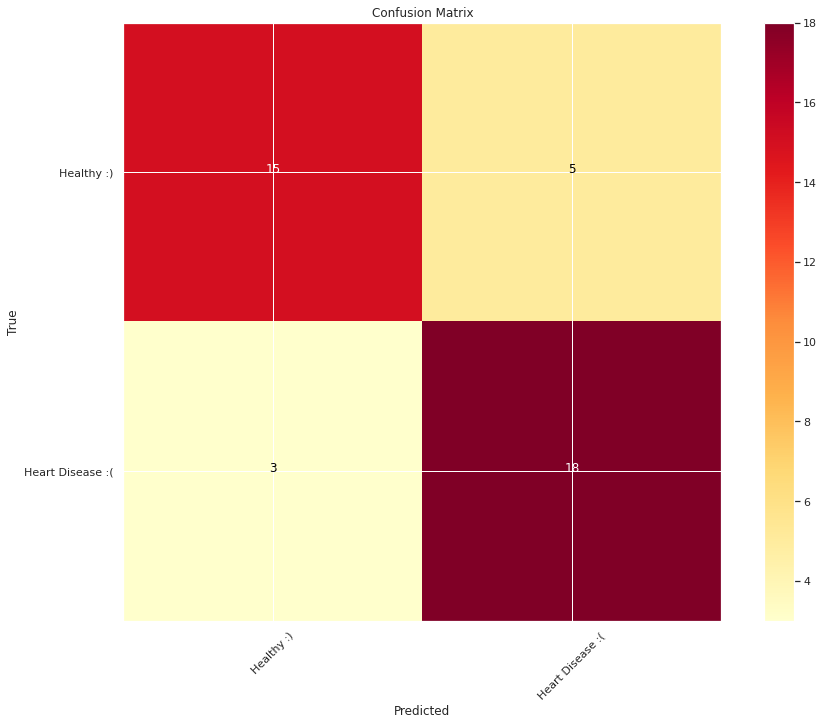

In [0]:
# Plot confusion matrix  
plot_confusion_matrix(cm, "Confusion Matrix")


##Feature importance using  RF & Pipeline

In [0]:
df1.dtypes

Out[312]: [('age', 'double'),
 ('sex', 'double'),
 ('cp', 'double'),
 ('trestbps', 'double'),
 ('chol', 'double'),
 ('fbs', 'double'),
 ('restecg', 'double'),
 ('thalach', 'double'),
 ('exang', 'double'),
 ('oldpeak', 'double'),
 ('slope', 'double'),
 ('ca', 'int'),
 ('thal', 'int'),
 ('target', 'int')]

In [0]:
train1, test1 = df1.randomSplit([0.8, 0.20], seed=1)

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# Define the categorical columns
categorical_columns = ['ca','sex','cp','fbs','restecg','exang','slope','thal' ]

# Define the numerical columns
numerical_columns = ['age', 'trestbps', 'chol', 
                     'thalach', 'oldpeak']

# Define the target column
target_column = "target"

# Create an indexer for each categorical column
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid='keep') for col in categorical_columns]

# Create an encoder for each indexed column
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_columns]


# Combine the numerical and categorical columns into a single feature vector
assembler = VectorAssembler(inputCols=numerical_columns + [col + "_encoded" for col in categorical_columns], outputCol="features")

In [0]:
# Create a Random Forest Classifier
random_forest = RandomForestClassifier(featuresCol="features", labelCol=target_column)

# Build the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, random_forest])

# Train the model
rfModel = pipeline.fit(df1)


In [0]:
# Get the list of feature names
feature_names = assembler.getInputCols()

# Get the feature importance values from the decision tree model
feature_importances = rfModel.stages[-1].featureImportances.toArray()

# Create a list of tuples of feature names and their indices
feature_list = list(zip(feature_names, range(len(feature_names))))

# Map the feature importance values to the feature names
feature_importance_mapping = [(feature, importance) for (feature, index), importance in zip(feature_list, feature_importances)]

# Sort the feature importance mapping in descending order by importance
sorted_feature_importance_mapping = sorted(feature_importance_mapping, key=lambda x: x[1], reverse=True)

# Print the feature importance mapping
print("Feature Importance Mapping:")
for feature, importance in sorted_feature_importance_mapping:
    print("{}: {}".format(feature, importance))



Feature Importance Mapping:
ca_encoded: 0.1598291322890071
slope_encoded: 0.08398745929683385
oldpeak: 0.07964814080950092
thalach: 0.07366478755890168
age: 0.05109652323860351
trestbps: 0.0487838685239255
chol: 0.03942585291200479
thal_encoded: 0.024813482239649683
exang_encoded: 0.02003542067133417
restecg_encoded: 0.019328041568663364
sex_encoded: 0.01151545314508467
cp_encoded: 0.010491393289233132
fbs_encoded: 0.002358851509729337


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

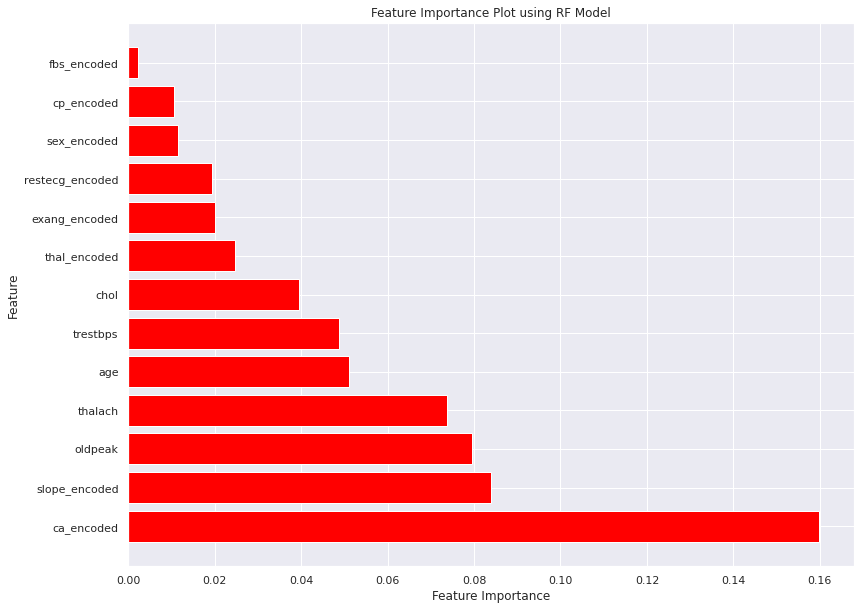

In [0]:
# set feature based on the above
features, importances = zip(*sorted_feature_importance_mapping)

#plot
plt.barh(features, importances, color='red')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")

plt.title("Feature Importance Plot using RF Model")
sns.set(rc={'figure.figsize':(13,10)})

plt.show()
